In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
import xml.dom.minidom as xmldom
import os
import random
import math

In [2]:
def height_shift_image( image, height_shift_range, boundingbox ):
    
    img_height, img_width = image.shape[:2]
    factor = height_shift_range * img_height
    
    M = np.float32([[1,0,0],[0,1,factor]]) 
    shifted_image = cv2.warpAffine( image, M, (img_width, img_height) )
    
   
    shifted_point_A = np.matmul( M, np.array( [boundingbox[0], boundingbox[1], 1] ).T )   
    shifted_point_C = np.matmul( M, np.array( [boundingbox[2], boundingbox[3], 1] ).T )   
    
    new_boundingbox = [ shifted_point_A[0].astype(int), shifted_point_A[1].astype(int), 
                        shifted_point_C[0].astype(int), shifted_point_C[1].astype(int) ]
    
    return shifted_image, new_boundingbox

In [3]:
def width_shift_image( image, width_shift_range, boundingbox ):
    
    img_height, img_width = image.shape[:2]
    factor = img_width * width_shift_range
    
    M = np.float32([[1,0,factor],[0,1,0]]) 
    shifted_image = cv2.warpAffine( image, M, (img_width, img_height) )
    
   
    shifted_point_A = np.matmul( M, np.array( [boundingbox[0], boundingbox[1], 1] ).T )   
    shifted_point_C = np.matmul( M, np.array( [boundingbox[2], boundingbox[3], 1] ).T )   
    
    new_boundingbox = [ shifted_point_A[0].astype(int), shifted_point_A[1].astype(int), 
                        shifted_point_C[0].astype(int), shifted_point_C[1].astype(int) ]
    
    return shifted_image, new_boundingbox

In [4]:
def rotate_image( image, angle, bounding_box ):
    
    
    img_height, img_width = image.shape[:2]
    
    # get rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D( center = (img_width // 2, img_height // 2), angle = angle, scale = 1.0 )
   
    # apply transformation (ratate image) 
    rotated_image = cv2.warpAffine( image, rotation_matrix, (img_width, img_height) )
    
    # --- compute new bounding box ---
    # Apply same transformation to the four bounding box corners
    rotated_point_A = np.matmul( rotation_matrix, np.array( [bounding_box[0], bounding_box[1], 1] ).T )   
    rotated_point_B = np.matmul( rotation_matrix, np.array( [bounding_box[2], bounding_box[1], 1] ).T )   
    rotated_point_C = np.matmul( rotation_matrix, np.array( [bounding_box[2], bounding_box[3], 1] ).T )   
    rotated_point_D = np.matmul( rotation_matrix, np.array( [bounding_box[0], bounding_box[3], 1] ).T )   
    # Compute new bounding box, that is, the bounding box for rotated object
    x = np.array( [ rotated_point_A[0], rotated_point_B[0], rotated_point_C[0], rotated_point_D[0] ])
    y = np.array( [ rotated_point_A[1], rotated_point_B[1], rotated_point_C[1], rotated_point_D[1] ])
    new_boundingbox = [np.min( x ).astype(int), np.min( y ).astype(int), np.max( x ).astype(int), np.max( y ).astype(int)]
    
    return rotated_image, new_boundingbox

In [5]:
def scale_image( image, scale_factor, boundingbox ): #圖片，放大縮小的數值，bb

    img_height, img_width = img.shape[:2]

    width = (int)(scale_factor * img_width)
    height = (int)(scale_factor * img_height)
    
    scaled_img = cv2.resize( image, (width,height) )

    scaling_marix = np.array( [ [scale_factor, 0, 0], [0, scale_factor, 0], [0, 0, scale_factor] ] ) #縮放矩陣形式

    scaled_point_A = np.matmul( scaling_marix, np.array( [boundingbox[0], boundingbox[1], 1] ).T )   
    scaled_point_C = np.matmul( scaling_marix, np.array( [boundingbox[2], boundingbox[3], 1] ).T )   

    new_boundingbox = [ scaled_point_A[0].astype(int), scaled_point_A[1].astype(int), 
                        scaled_point_C[0].astype(int), scaled_point_C[1].astype(int) ]
    
    return scaled_img, new_boundingbox

取得xml檔資料xywh

In [6]:
def parse_xml(fn):
    xml_file = xmldom.parse(fn)
    eles = xml_file.documentElement
    #print(eles.tagName)
    xmin = eles.getElementsByTagName("xmin")[0].firstChild.data
    xmax = eles.getElementsByTagName("xmax")[0].firstChild.data
    ymin = eles.getElementsByTagName("ymin")[0].firstChild.data
    ymax = eles.getElementsByTagName("ymax")[0].firstChild.data
    return [xmin,ymin,xmax, ymax]

In [7]:
def draw_boundingbox( image, tl, br ):
    copied_image = image.copy()
    image = cv2.rectangle(copied_image, tl, br, (0, 0, 255), 5) #顏色，粗細
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)          
    return image

In [9]:
def plot_images( images_list ):   
    num_cols = 5   
    num_rows = math.ceil( len(images_list) / num_cols )
    fig = plt.figure(figsize = (50,50)) #figsize = (50,50)改變原來圖片畫布大小問題   
    for i in range (0, len(images_list) ): 
        info = images_list[i]
        x1, y1, x2, y2 = info[1]   #四個座標    
        image = draw_boundingbox( info[0], (x1, y1), (x2, y2) )      
        axi = fig.add_subplot(num_rows, num_cols, i+1)
        #axi.axis( 'off' )
        axi.set_title( ("%.1f" % info[2] ) )
        image = image[:,:,[2,1,0]] #轉圖片顏色
        #cv2.imwrite("Pictures\\test\\"+ "dot" + str(count+1) + ".JPG", info[0][:,:,[2,1,0]])       
        print("資料擴增後的像素位置"+str(info[1]))
        plt.imshow(image)
        plt.show()
        #dot_image_regions["dot"+str(count+1) + ".JPG"] = [x1/4592, y1/2576, (x2-x1)/4592, (y2-y1)/2576]  
        
        #print("新增的dict圖片和標準化座標"+str(dot_image_regions))

In [10]:
def apply_transformation( image, bounding_box, transformation, n ):   #n要幾張圖片
    t_images_list = []
    
    for i in range(0, n):
        interval = f_dic[transformation]
        factor = random.uniform(interval[0], interval[1]) #uniform()是不能直接訪問的，需要導入 random 模塊，然後通過 random 靜態對象調用該方法。
        img, bb = t_dic[transformation]( image, factor, bounding_box ) #從一個均勻分佈[low,high)中隨機取
        #tic[transformation]取得字典裡面的function，後面括號把參數傳進去，返回兩個參數
        t_images_list.append( (img, bb, factor) )
        
    return t_images_list

資料擴增的dict

In [11]:
t_dic = { "rotation":rotate_image, "width_shift":width_shift_image, "height_shift":height_shift_image, "scale": scale_image }
f_dic = { "rotation":(0, 90), "width_shift":(0, 0.5), "height_shift":(0, 0.5), "scale": (0.5, 1.5)}

將所有xml檔案新增到陣列

In [15]:
original_boundingbox = []
xmlDirPath = './HW2Imagel/abels/'   
files= os.listdir(xmlDirPath)
for filename in files: #遍歷資料夾 
    print(filename)
    if filename.find('.xml') > 0:   #不知道為什麼當把原本的資料複製到另外一份，或多了一個.DS_Store檔，所以多增加以下判斷  
        original_boundingbox.append(parse_xml(xmlDirPath + filename))#取得所有xml檔裡面的xywh  

FileNotFoundError: [Errno 2] No such file or directory: './HW2Imagel/abels/'

In [13]:
original_boundingbox  #檢查像素座標是否正確

[['77', '85', '123', '147']]

套用所有以上func，並且同時呈現出圖片

資料擴增後的像素位置[97, 537, 173, 605]


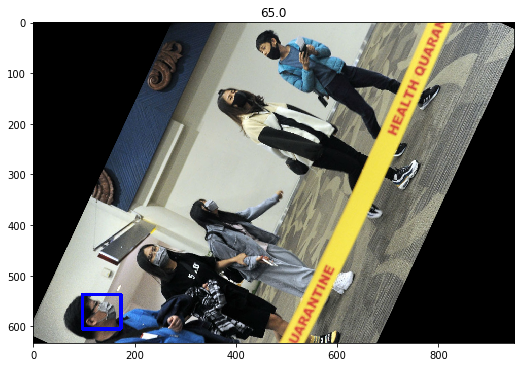

資料擴增後的像素位置[91, 85, 137, 147]


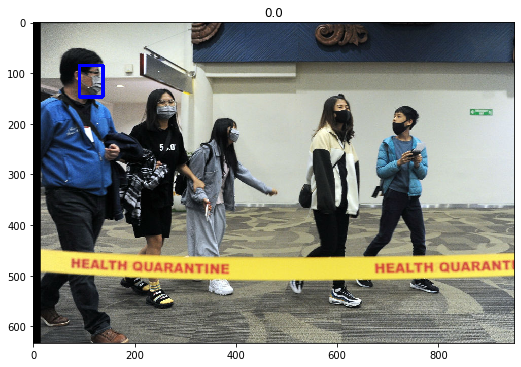

資料擴增後的像素位置[77, 242, 123, 304]


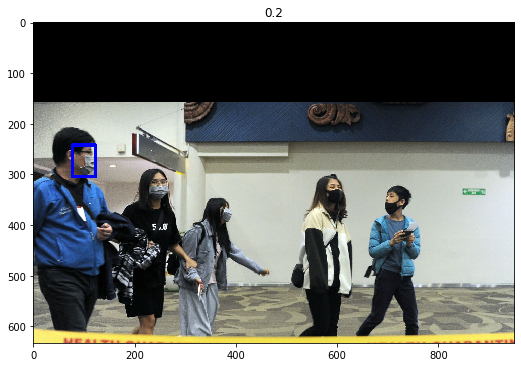

資料擴增後的像素位置[91, 101, 146, 175]


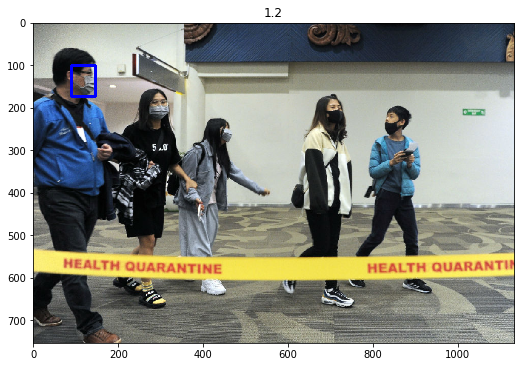

In [14]:
imageDirPath="/Users/jennielin/Downloads/HW2Image/images/"
imgfiles= os.listdir(imageDirPath)

for i in range(len(original_boundingbox)):    
    original_boundingbox[i] = list(map(int, original_boundingbox[i])) #str list to int list #從xml出來的是字串
    for j in range(len(imgfiles)):
        if(i == j):
            img = cv2.imread(imageDirPath + imgfiles[j])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
            
            rotated_images = apply_transformation( img, original_boundingbox[i], "rotation", 1 )
            plot_images(rotated_images)

            w_shifted_images = apply_transformation( img, original_boundingbox[i], "width_shift", 1 )
            plot_images(w_shifted_images)

            h_shifted_images = apply_transformation( img, original_boundingbox[i], "height_shift", 1 )
            plot_images(h_shifted_images)
            
            scale_image = apply_transformation( img, original_boundingbox[i], "scale", 1 )
            plot_images(scale_image)